In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk


## Load the Dataset
The dataset contains rental prices for houses in **Dhaka**.  Let's first load it and take a quick look.

In [2]:
# Load dataset
df = pd.read_csv("houserentdhaka.csv")
# Display the first few rows of the dataset
df.head()

,Unnamed: 0,Location,Area,Bed,Bath,Price
0,0,"Block H, Bashundhara R-A, Dhaka","1,600 sqft",3,3,20 Thousand
1,1,"Farmgate, Tejgaon, Dhaka",900 sqft,2,2,20 Thousand
2,2,"Block B, Nobodoy Housing Society, Mohammadpur,...","1,250 sqft",3,3,18 Thousand
3,3,"Gulshan 1, Gulshan, Dhaka","2,200 sqft",3,4,75 Thousand
4,4,"Baridhara, Dhaka","2,200 sqft",3,3,75 Thousand


## Understanding the Dataset Structure

Before diving into analysis, let's explore the dataset to understand its structure, available features, and data types.


In [3]:
df.shape

(28800, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  28800 non-null  int64 
 1   Location    28800 non-null  object
 2   Area        28800 non-null  object
 3   Bed         28800 non-null  int64 
 4   Bath        28800 non-null  int64 
 5   Price       28800 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.3+ MB


# Data Preprocessing

In [5]:
# # Rename the "Price" column to "Rent" for better clarity 
df.rename({"Price" : "Rent"}, axis = 1, inplace = True)

In [6]:
# Dropping unnecessary column
df.drop(df.columns[0], axis = 1, inplace = True)

In [7]:
df.dtypes

Location    object
Area        object
Bed          int64
Bath         int64
Rent        object
dtype: object

In [8]:
df.head(3)

,Location,Area,Bed,Bath,Rent
0,"Block H, Bashundhara R-A, Dhaka","1,600 sqft",3,3,20 Thousand
1,"Farmgate, Tejgaon, Dhaka",900 sqft,2,2,20 Thousand
2,"Block B, Nobodoy Housing Society, Mohammadpur,...","1,250 sqft",3,3,18 Thousand


In [9]:
# Keeping only the thana/PO/area name in the Location column
df["Location"] = df["Location"].str.split(",").str[:-1].str[-1]
df['Location'] = df['Location'].str.strip()

In [10]:
# Display the first few rows of the dataset
df.head()

,Location,Area,Bed,Bath,Rent
0,Bashundhara R-A,"1,600 sqft",3,3,20 Thousand
1,Tejgaon,900 sqft,2,2,20 Thousand
2,Mohammadpur,"1,250 sqft",3,3,18 Thousand
3,Gulshan,"2,200 sqft",3,4,75 Thousand
4,Baridhara,"2,200 sqft",3,3,75 Thousand


#### Cleaning & Converting Area Data

The `"Area"` column in our dataset contains values in a **text format**, often including unit labels like `"sqft"` or commas for readability (e.g., `"1,200 sqft"`).  
Since we need **numeric values** for analysis, we will process the column as follows:

In [11]:
df["Area"] = df["Area"].str.split(" ").str[:-1]

In [12]:
df["Area"] = df['Area'].apply(lambda x: ''.join(map(str, x)))

In [13]:
df['Area']=df['Area'].str.replace(',', '')
df['Area'] = df['Area'].astype(int)

In [14]:
df["Area"].dtypes

dtype('int64')

#### Converting Rent Values to Numeric Format

In our dataset, the `"Rent"` column contains values in a **mixed format**. Some rents are written with text labels like **"Thousand"** or **"Lakh"**, which need to be converted into numerical values for accurate calculations.


In [15]:
# Convert rent values from text-based to numeric format
df["Rent"] = df["Rent"].replace({"Thousand":"*1e3", "Lakh":"*1e5"}, regex=True).map(pd.eval).astype(int)

#### Handling Missing Values

Real-world datasets often contain **missing values**, which can impact the performance of machine learning models.  
To ensure data integrity, we will first **check for missing values** and then decide how to handle them.

In [16]:
df.isna().sum()

Location    13
Area         0
Bed          0
Bath         0
Rent         0
dtype: int64

In [17]:
df.dropna(inplace= True)

#### Calculating Price Per Square Foot

To better understand the cost dynamics of rental properties, we compute the **price per square foot** (`price_per_sqft`).  
This helps in comparing rental values across different property sizes.

In [18]:
df['price_per_sqft'] = (df['Rent']/df['Area']).round(2)
df.head()

,Location,Area,Bed,Bath,Rent,price_per_sqft
0,Bashundhara R-A,1600,3,3,20000,12.50
1,Tejgaon,900,2,2,20000,22.22
2,Mohammadpur,1250,3,3,18000,14.40
3,Gulshan,2200,3,4,75000,34.09
4,Baridhara,2200,3,3,75000,34.09


# Outlier Removal Using Standard Deviation and Mean

In [19]:
df.price_per_sqft.describe()

count    28787.000000
mean        19.015038
std          6.553137
min          6.500000
25%         15.380000
50%         18.060000
75%         21.050000
max        228.570000
Name: price_per_sqft, dtype: float64


Here we find that min price per sqft is near about 19 tk /sqft whereas max is almost 229, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation


#### Removing Outliers Based on Price Per Square Foot

Property rent prices can vary significantly across different locations. To ensure a **clean dataset**, we detect and remove **outliers** using the **mean and standard deviation** of `price_per_sqft` for each location.

In [20]:
## Calculate mean & standard deviation of price_per_sqft per location
location_stats = df.groupby('Location')['price_per_sqft'].agg(['mean', 'std'])

# Merging the stats back with the original DataFrame to get the mean and std per location
df = df.merge(location_stats, on='Location', how='left')

# Calculating lower and upper bounds for outlier detection
df['lower_bound'] = df['mean'] - df['std']
df['upper_bound'] = df['mean'] + df['std']

# Filtering the data to remove outliers based on price_per_sqft within the bounds
df_filtered = df[(df['price_per_sqft'] >= df['lower_bound']) & (df['price_per_sqft'] <= df['upper_bound'])]

# Droping the auxiliary columns
df_filtered = df_filtered.drop(columns=['mean', 'std', 'lower_bound', 'upper_bound'])


In [21]:
## Drop auxiliary columns used for outlier detection
df_filtered = df_filtered.drop(columns=['price_per_sqft'])

Text(0, 0.5, 'Count')

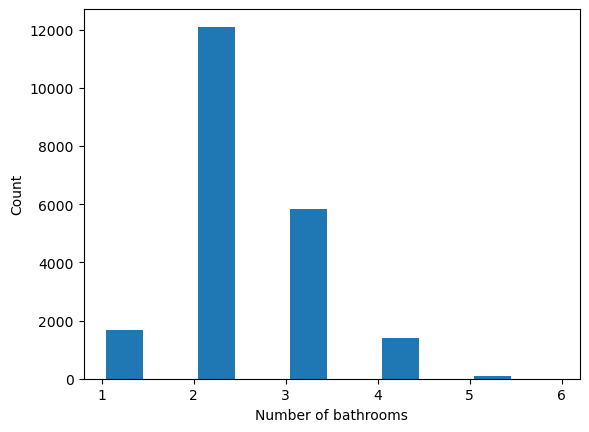

In [22]:
# Visualization improvement: Add labels & title
plt.hist(df_filtered.Bath,rwidth=0.8)
# Visualization improvement: Add labels & title
plt.xlabel("Number of bathrooms")
# Visualization improvement: Add labels & title
plt.ylabel("Count")

# Exploratory Data Analysis (EDA)

In [23]:
df_filtered.describe()

,Area,Bed,Bath,Rent
count,21118.000000,21118.000000,21118.000000,21118.000000
mean,1036.572450,2.479591,2.345866,20376.671939
std,466.278478,0.591758,0.740388,17405.918894
min,300.000000,1.000000,1.000000,5500.000000
25%,700.000000,2.000000,2.000000,13000.000000
50%,860.000000,2.000000,2.000000,16000.000000
75%,1200.000000,3.000000,3.000000,22000.000000
max,6300.000000,6.000000,6.000000,400000.000000


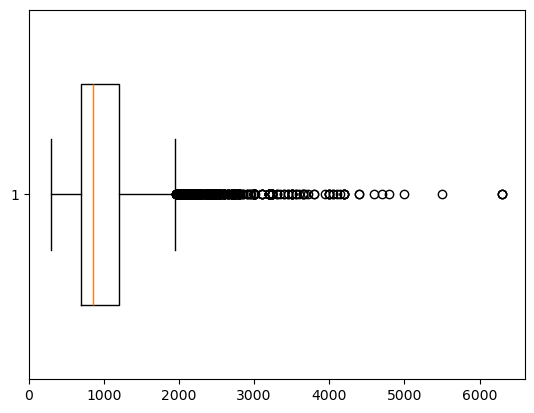

In [24]:
# Visualization improvement: Add labels & title
plt.boxplot(df_filtered["Area"], vert=False, widths = 0.6)
# Visualization improvement: Add labels & title
plt.show()

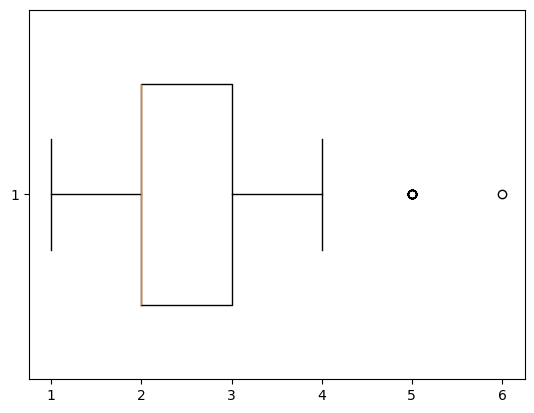

In [25]:
# Visualization improvement: Add labels & title
plt.boxplot(df_filtered["Bed"], vert=False, widths = 0.6)
# Visualization improvement: Add labels & title
plt.show()


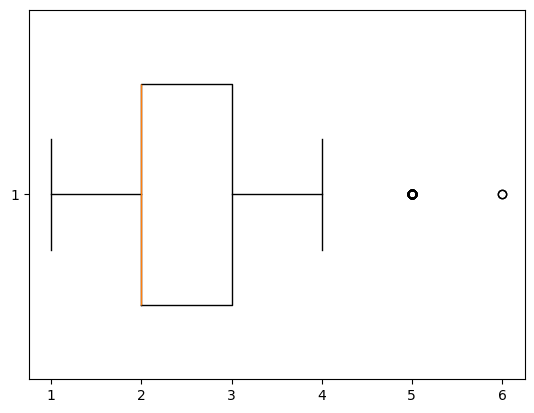

In [26]:
# Visualization improvement: Add labels & title
plt.boxplot(df_filtered["Bath"], vert=False, widths = 0.6)
# Visualization improvement: Add labels & title
plt.show()

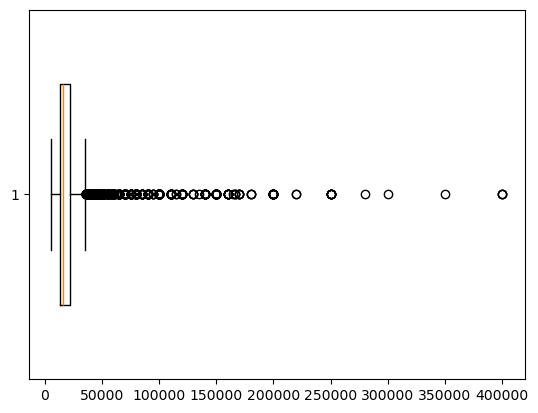

In [27]:
# Visualization improvement: Add labels & title
plt.boxplot(df_filtered["Rent"], vert=False, widths = 0.6)
# Visualization improvement: Add labels & title
plt.show()

In [28]:
df_filtered["Location"].value_counts()

Location
Mirpur             6293
Mohammadpur        2430
Uttara             1577
Badda              1322
Bashundhara R-A    1228
                   ... 
Shahbagh              5
Demra                 4
Sadarghat             2
Banglamotors          2
Keraniganj            2
Name: count, Length: 68, dtype: int64

In [29]:
df_filtered["Bed"].value_counts()

Bed
2    11250
3     8843
4      747
1      261
5       16
6        1
Name: count, dtype: int64

In [30]:
df_filtered["Bath"].value_counts()

Bath
2    12101
3     5838
1     1667
4     1405
5      105
6        2
Name: count, dtype: int64

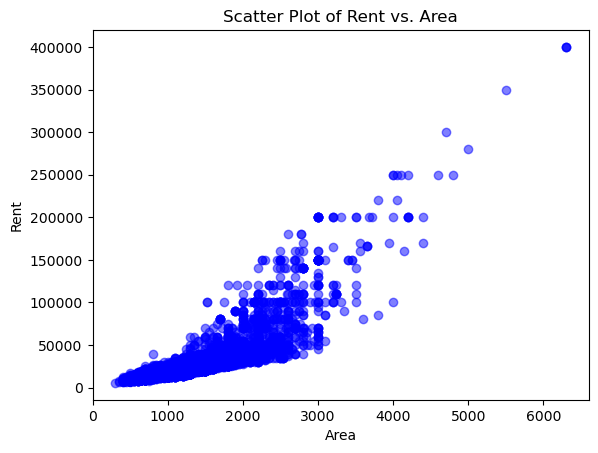

In [31]:
# Visualization improvement: Add labels & title
plt.scatter(df_filtered["Area"], df_filtered["Rent"], alpha=0.5, color='blue')
# Visualization improvement: Add labels & title
plt.xlabel("Area")
# Visualization improvement: Add labels & title
plt.ylabel("Rent")
# Visualization improvement: Add labels & title
plt.title("Scatter Plot of Rent vs. Area")
# Visualization improvement: Add labels & title
plt.show()

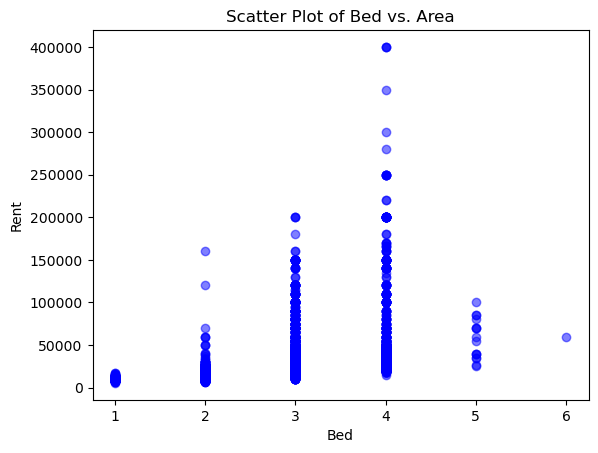

In [32]:
# Visualization improvement: Add labels & title
plt.scatter(df_filtered["Bed"], df_filtered["Rent"], alpha=0.5, color='blue')
# Visualization improvement: Add labels & title
plt.xlabel("Bed")
# Visualization improvement: Add labels & title
plt.ylabel("Rent")
# Visualization improvement: Add labels & title
plt.title("Scatter Plot of Bed vs. Area")
# Visualization improvement: Add labels & title
plt.show()

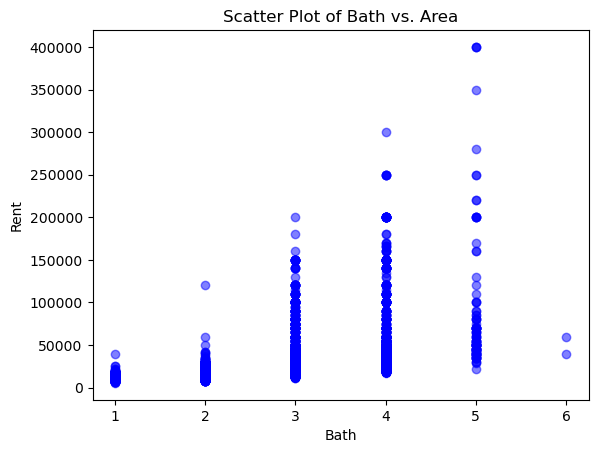

In [33]:
# Visualization improvement: Add labels & title
plt.scatter(df_filtered["Bath"], df_filtered["Rent"], alpha=0.5, color='blue')
# Visualization improvement: Add labels & title
plt.xlabel("Bath")
# Visualization improvement: Add labels & title
plt.ylabel("Rent")
# Visualization improvement: Add labels & title
plt.title("Scatter Plot of Bath vs. Area")
# Visualization improvement: Add labels & title
plt.show()

In [34]:
df_numerical = df_filtered.drop(columns=[df.columns[0]]) 
df_numerical.corr(method ='pearson')

,Area,Bed,Bath,Rent
Area,1.000000,0.785905,0.813116,0.818738
Bed,0.785905,1.000000,0.763950,0.513299
Bath,0.813116,0.763950,1.000000,0.559004
Rent,0.818738,0.513299,0.559004,1.000000


Text(0.5, 1.0, 'Pearson Correlation')

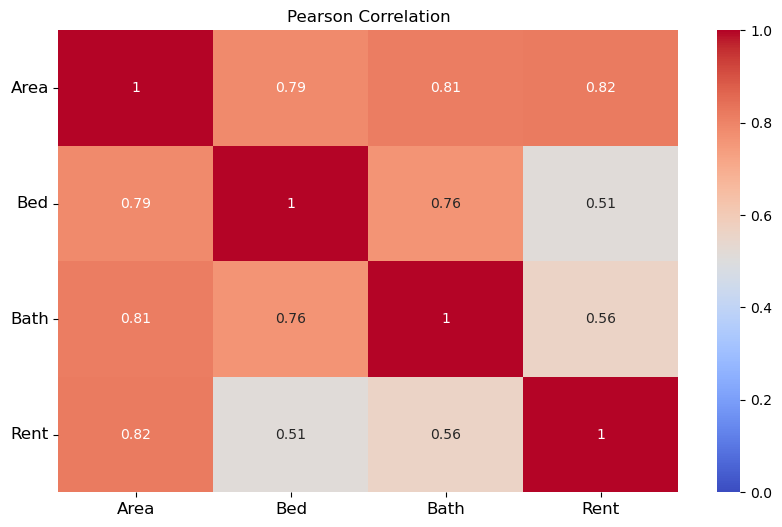

In [35]:
# Create heatmap
# Visualization improvement: Add labels & title
plt.figure(figsize=(10,6))
# Visualization improvement: Add labels & title
heatmap = sns.heatmap(df_numerical.corr(method ='pearson'), vmin=0,vmax=1, annot=True, cmap = "coolwarm")
# Visualization improvement: Add labels & title
plt.xticks(rotation=0, fontsize=12)  
# Visualization improvement: Add labels & title
plt.yticks(rotation=0, fontsize=12)
# Visualization improvement: Add labels & title
plt.title("Pearson Correlation")

### As it is observed, Area has the highest impact on Rent 0.82

# One Hot Encoding For Location

In [36]:
dummies = pd.get_dummies(df_filtered.Location).astype("int")
dummies.head(3)

,Adabor,Aftab Nagar,Agargaon,Badda,Banani,Banani DOHS,Banasree,Banglamotors,Bangshal,Baridhara,...,Shiddheswari,Shyamoli,Shyampur,Sutrapur,Taltola,Tejgaon,Turag,Uttar Khan,Uttara,Zafrabad
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_new = pd.concat([df_filtered,dummies],axis='columns')
# Display the first few rows of the dataset
df_new.head()

,Location,Area,Bed,Bath,Rent,Adabor,Aftab Nagar,Agargaon,Badda,Banani,...,Shiddheswari,Shyamoli,Shyampur,Sutrapur,Taltola,Tejgaon,Turag,Uttar Khan,Uttara,Zafrabad
1,Tejgaon,900,2,2,20000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Mohammadpur,1250,3,3,18000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Gulshan,2200,3,4,75000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baridhara,2200,3,3,75000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Bashundhara R-A,3000,4,5,50000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_new =df_new.drop("Location",axis =1)

In [39]:
df_new.head(3)

,Area,Bed,Bath,Rent,Adabor,Aftab Nagar,Agargaon,Badda,Banani,Banani DOHS,...,Shiddheswari,Shyamoli,Shyampur,Sutrapur,Taltola,Tejgaon,Turag,Uttar Khan,Uttara,Zafrabad
1,900,2,2,20000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1250,3,3,18000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2200,3,4,75000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature Scalling

In [40]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

df_scaled = df_new.copy()

# Columns to normalize
columns_to_normalize = ['Area', 'Bed', 'Bath', 'Rent']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df_scaled[columns_to_normalize] = scaler.fit_transform(df_new[columns_to_normalize])

# Display the first 5 rows
# Display the first few rows of the dataset
df_scaled.head()

,Area,Bed,Bath,Rent,Adabor,Aftab Nagar,Agargaon,Badda,Banani,Banani DOHS,...,Shiddheswari,Shyamoli,Shyampur,Sutrapur,Taltola,Tejgaon,Turag,Uttar Khan,Uttara,Zafrabad
1,0.100000,0.2,0.2,0.036755,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.158333,0.4,0.4,0.031686,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.316667,0.4,0.6,0.176172,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.316667,0.4,0.4,0.176172,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.450000,0.6,0.8,0.112801,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Building Model


In [41]:
X = df_scaled.drop("Rent", axis =1)
X.head(3)

,Area,Bed,Bath,Adabor,Aftab Nagar,Agargaon,Badda,Banani,Banani DOHS,Banasree,...,Shiddheswari,Shyamoli,Shyampur,Sutrapur,Taltola,Tejgaon,Turag,Uttar Khan,Uttara,Zafrabad
1,0.100000,0.2,0.2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.158333,0.4,0.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.316667,0.4,0.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X.shape

(21118, 71)

In [43]:
y = df_scaled.Rent

In [44]:
y

1        0.036755
2        0.031686
3        0.176172
4        0.176172
5        0.112801
           ...   
28779    0.138150
28780    0.036755
28781    0.024081
28783    0.049430
28785    0.062104
Name: Rent, Length: 21118, dtype: float64

Now that we have **cleaned and preprocessed the dataset**, it's time to build a **Linear Regression model** to predict house rent.


In [45]:
# Import necessary libraries for split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [46]:
# Import necessary libraries

from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8841062274325822

#### Finding the Best Model for House Rent Prediction

To ensure we select the most **accurate and efficient** model, we compare multiple machine learning algorithms using **GridSearchCV**.

---

#### 🔹 **Why Compare Multiple Models?**
Different algorithms perform **differently** based on the **data structure** and **features**.  
By testing multiple models, we can identify the **best-performing one** for house rent prediction.

---

#### **Models Compared:**
1️⃣ **Linear Regression** – Simple and interpretable.  
2️⃣ **Decision Tree Regressor** – Captures non-linearity but can overfit.  
3️⃣ **Random Forest Regressor** – An ensemble method reducing overfitting.  
4️⃣ **XGBoost Regressor** – A powerful gradient boosting model.  
5️⃣ **Support Vector Machine (SVR)** – Works well with small datasets and complex relationships.  
6️⃣ **Bayesian Ridge Regression** – A probabilistic approach to regression.

---

#### **How We Compare the Models**
✔ **Hyperparameter tuning** using **GridSearchCV**.  
✔ **Cross-validation (ShuffleSplit)** to ensure robust evaluation.  
✔ **Best model is selected** based on performance scores.



In [47]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import pandas as pd


# Function to find the best model using GridSearchCV
def find_best_model_using_gridsearchcv(X, y):

    # Define models and their parameters 
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best','random'],
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50,100],
                'criterion': ['squared_error','friedman_mse'],
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [50,100],
                'learning_rate': [0.01,0.1],
                'max_depth': [3,5],
            }
        },
        'svm': {
            'model': SVR(),
            'params': {
                'kernel': ['linear','rbf'],
                'C': [0.1,1],
                'epsilon': [0.1,0.2],
            }
        },
        'bayesian_ridge': {
            'model': BayesianRidge(),
            'params': {
                'alpha_1': [1e-3],
                'alpha_2': [1e-3],
                'lambda_1': [1e-3],
                'lambda_2': [1e-3],
            }
        }
    }

    # ShuffleSplit Cross-validation
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    scores = []
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

best_model_df = find_best_model_using_gridsearchcv(X, y)
print(best_model_df)


               model  best_score  \
0  linear_regression    0.893925   
1      decision_tree    0.938024   
2      random_forest    0.950257   
3            xgboost    0.932277   
4                svm    0.402619   
5     bayesian_ridge    0.893914   

                                         best_params  
0                            {'fit_intercept': True}  
1  {'criterion': 'friedman_mse', 'splitter': 'best'}  
2  {'criterion': 'squared_error', 'n_estimators':...  
3  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  
4     {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}  
5  {'alpha_1': 0.001, 'alpha_2': 0.001, 'lambda_1...  


### Training the Best Model - Random Forest Regressor

After evaluating multiple models using **GridSearchCV**, we found that **Random Forest Regressor** achieved the **highest performance score**.  
Therefore, we proceed with training it on our dataset.

---

### 🔹 **Why Random Forest?**
✅ **Performs well on structured data** with complex relationships.  
✅ **Handles non-linearity** better than simple linear models.  
✅ **Less prone to overfitting** compared to a single Decision Tree.  
✅ **Automatically captures feature importance**, helping us understand key factors influencing rent.


In [48]:
# Random Forest model
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, criterion='squared_error', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
model.score(X_test, y_test)



0.9565388530562258

### Building a House Rent Prediction Function

Now that we have a trained **Random Forest Regressor**, we create a **custom function** to predict house rent based on user input.

---

### 🔹 **How Does `predict_price` Work?**
1️⃣ **Prepare input features**:  
   - Create a zero-filled array of the same size as `X.columns`.  
   - Scale numerical inputs (`Area`, `Bed`, `Bath`) using a **pre-fitted scaler**.  

2️⃣ **One-Hot Encode Location**:  
   - Since `Location` is categorical, we check if it exists in `X.columns`.  
   - If it does, we set its corresponding **one-hot encoded** index to `1`.  

3️⃣ **Make a Prediction**:  
   - The trained model predicts the **scaled rent value**.  
   - We **convert it back to the actual rent** using the **min-max range** for the given location.

---

In [49]:
def predict_price(Location, Area, Bed, Bath):
    # Create an array of zeros for input features
    x = np.zeros(len(X.columns))  

    # Scale input values correctly
    scaled_features = scaler.transform([[Area, Bed, Bath, 0]])[0]
    x[0] = scaled_features[0]  # Scaled Areaz
    x[1] = scaled_features[1]  # Scaled Bed
    x[2] = scaled_features[2]  # Scaled Bath

    # One-hot encode location
    if Location in X.columns:
        loc_index = np.where(X.columns == Location)[0][0]
        x[loc_index] = 1  # Set one-hot encoding for location

    # Predict scaled rent
    scaled_predicted_rent = model.predict([x])[0]

    # Geting location-specific min/max Rent

    min_rent = df_new[df_new[Location] == 1]['Rent'].min()
    max_rent = df_new[df_new[Location] == 1]['Rent'].max()

    actual_predicted_rent = scaled_predicted_rent * (max_rent - min_rent) + min_rent

    return actual_predicted_rent



## Predicting House Rent in Different Locations

Now that we have built the **rent prediction model**, let's test it by predicting rent prices in different locations.


In [50]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
predict_price('Gulshan',1000, 3, 2)

47811.181950093494

In [51]:
predict_price('Bashundhara R-A',1000, 2, 2)

12426.357181358626

In [52]:
predict_price('Baridhara',1000, 3, 2)

66228.57405325939